In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import re
from collections import defaultdict
from utils import plot_conf_mat

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# reading the data
df = pd.read_csv('data/train_data.csv')

In [3]:
# looking at the data
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [4]:
df.shape

(3321, 5)

***Splitting the Data into Train, Validation and Test sets***

In [5]:
y_true = df['Class']
df.Gene = df.Gene.str.replace('\s+', '_')
df.Variation = df.Variation.str.replace('\s+', '_')

In [6]:
# splitting into train and test
train_df, X_test, train_y, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2, random_state=42)

# splitting into train and validation 
X_train, X_val, y_train, y_val = train_test_split(train_df, train_y, stratify=train_y, test_size=0.2, random_state=42)

In [7]:
# checking the shapes
print(f"Shape of Train: {X_train.shape}, {y_train.shape}")
print(f"Shape of Validation: {X_val.shape}, {y_val.shape}")
print(f"Shape of Test: {X_test.shape}, {y_test.shape}")

Shape of Train: (2124, 5), (2124,)
Shape of Validation: (532, 5), (532,)
Shape of Test: (665, 5), (665,)


*Checking the Distribution of Dependent Feature (y) in Train, Test and Validation sets:*

In [8]:
train_class_dist = X_train['Class'].value_counts()
test_class_dist = X_test['Class'].value_counts()
val_class_dist = X_val['Class'].value_counts()

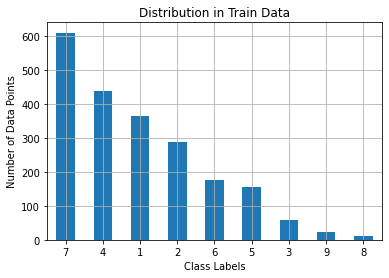

--------------------------------------------------------------------------------
Number of Data Points in Class 7 : 609 (28.672%)
Number of Data Points in Class 4 : 439 (20.669%)
Number of Data Points in Class 1 : 363 (17.090%)
Number of Data Points in Class 2 : 289 (13.606%)
Number of Data Points in Class 6 : 176 (8.286%)
Number of Data Points in Class 5 : 155 (7.298%)
Number of Data Points in Class 3 : 57 (2.684%)
Number of Data Points in Class 9 : 24 (1.130%)
Number of Data Points in Class 8 : 12 (0.565%)
--------------------------------------------------------------------------------


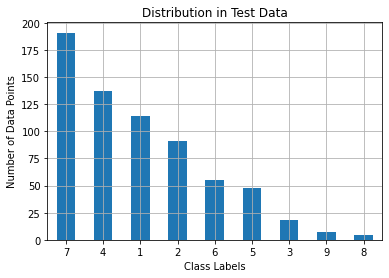

--------------------------------------------------------------------------------
Number of Data Points in Class 7 : 191 (28.722%)
Number of Data Points in Class 4 : 137 (20.602%)
Number of Data Points in Class 1 : 114 (17.143%)
Number of Data Points in Class 2 : 91 (13.684%)
Number of Data Points in Class 6 : 55 (8.271%)
Number of Data Points in Class 5 : 48 (7.218%)
Number of Data Points in Class 3 : 18 (2.707%)
Number of Data Points in Class 9 : 7 (1.053%)
Number of Data Points in Class 8 : 4 (0.602%)
--------------------------------------------------------------------------------


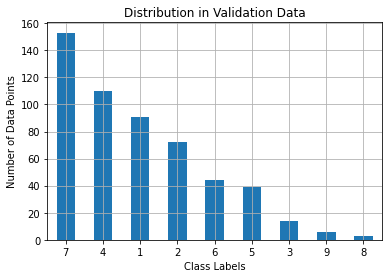

--------------------------------------------------------------------------------
Number of Data Points in Class 7 : 153 (28.759%)
Number of Data Points in Class 4 : 110 (20.677%)
Number of Data Points in Class 1 : 91 (17.105%)
Number of Data Points in Class 2 : 72 (13.534%)
Number of Data Points in Class 6 : 44 (8.271%)
Number of Data Points in Class 5 : 39 (7.331%)
Number of Data Points in Class 3 : 14 (2.632%)
Number of Data Points in Class 9 : 6 (1.128%)
Number of Data Points in Class 8 : 3 (0.564%)
--------------------------------------------------------------------------------


In [9]:
# distribution in Train Data
plt.figure()
train_class_dist.plot(kind='bar')
plt.xlabel('Class Labels')
plt.ylabel('Number of Data Points')
plt.title('Distribution in Train Data')
plt.xticks(rotation='horizontal')
plt.grid()
plt.show();

# printing the percentage and number of points:
print('-' * 80)
sorted_train_y = np.argsort(-train_class_dist.values)
for i in sorted_train_y:
    print(f'Number of Data Points in Class {train_class_dist.index[i]} : {train_class_dist.values[i]} ({train_class_dist.values[i] / train_class_dist.sum():.3%})')
print('-' * 80)

# distribution in Test Data
plt.figure()
test_class_dist.plot(kind='bar')
plt.xlabel('Class Labels')
plt.ylabel('Number of Data Points')
plt.title('Distribution in Test Data')
plt.xticks(rotation='horizontal')
plt.grid()
plt.show();

# printing the percentage and number of points:
print('-' * 80)
sorted_test_y = np.argsort(-test_class_dist.values)
for i in sorted_test_y:
    print(f"Number of Data Points in Class {test_class_dist.index[i]} : {test_class_dist.values[i]} ({test_class_dist.values[i] / test_class_dist.sum():.3%})")
print('-' * 80)

# distribution in Validation data
plt.figure()
val_class_dist.plot(kind='bar')
plt.xlabel('Class Labels')
plt.ylabel('Number of Data Points')
plt.title('Distribution in Validation Data')
plt.xticks(rotation='horizontal')
plt.grid()
plt.show();

# printing the percentage and number of points:
print('-' * 80)
sorted_val_y = np.argsort(-val_class_dist.values)
for i in sorted_val_y:
    print(f'Number of Data Points in Class {val_class_dist.index[i]} : {val_class_dist.values[i]} ({val_class_dist.values[i] / val_class_dist.sum():.3%})')
print('-' * 80)

## Random Model
*In a Random Model, we generate the NINE class probs randomly such that they sum to 1.*

- we need to generate 9 random probabilities whose sum is equal to 1.
- we will do this by generating 9 numbers and dividing each by their sum.

In [13]:
test_data_len = X_test.shape[0]
val_data_len = X_val.shape[0]

# creating the validation prediction array with same shape as validation set 
y_pred_val = np.zeros((cv_data_len, 9))

# generating random probabilities
for i in range(val_data_len):
    rand_probs = np.random.rand(1, 9)
    y_pred_val[i] = rand_probs / sum(sum(rand_probs))

# creating the test set prediction array with the same shape
y_pred_test = np.zeros((test_data_len, 9))

# generating random probabilities
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    y_pred_test[i] = rand_probs / sum(sum(rand_probs))

In [15]:
# calculating the log-loss of validation and test sets
ll_validation = log_loss(y_val, y_pred_val)
ll_test = log_loss(y_test, y_pred_test)

print(f"Log Loss on Validation Set: {ll_validation}")
print(f"Log Loss on Test Set: {ll_test}")

Log Loss on Validation Set: 2.4929927010715525
Log Loss on Test Set: 2.509888381583665


In [18]:
# Getting the predictions:
test_predictions = np.argmax(y_pred_test, axis=1)

CONFUSION MATRIX


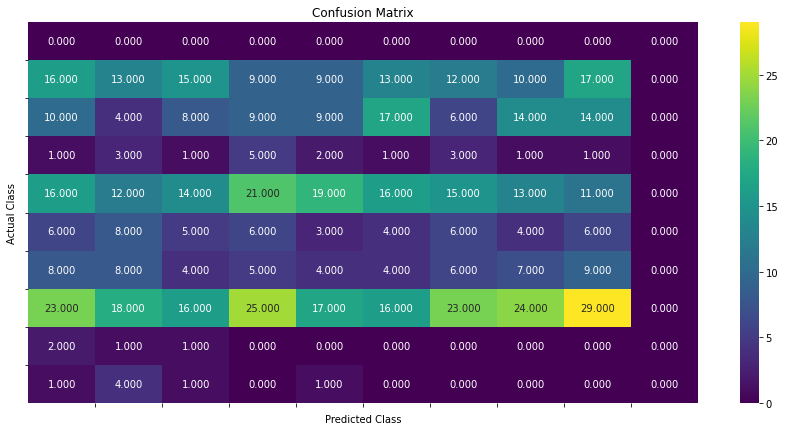

--------------------------------------------------------------------------------
PRECISION MATRIX


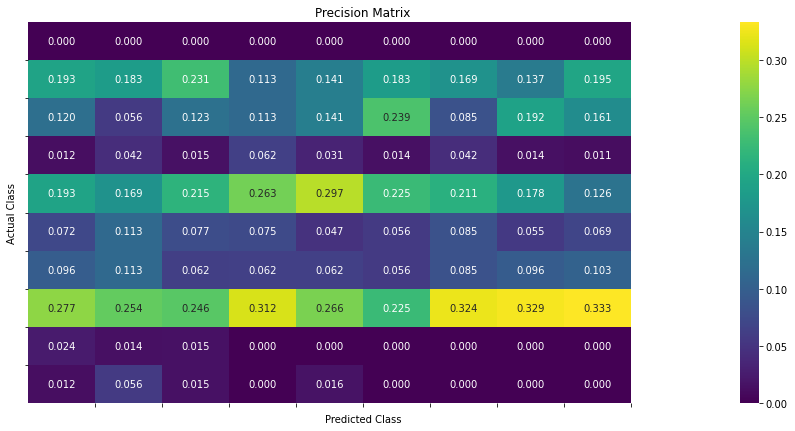

--------------------------------------------------------------------------------
RECALL MATRIX


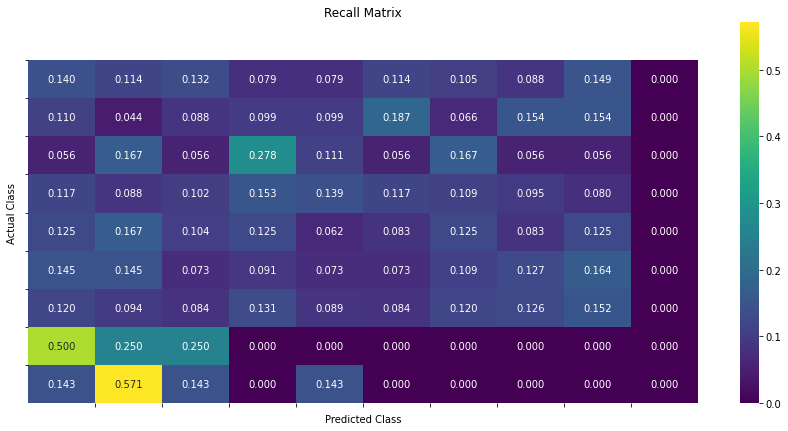

In [22]:
# plotting the confusion matrix
plot_conf_mat(y_test, test_predictions, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])

## Univariate Analysis

In [10]:
X_test.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'TEXT'], dtype='object')

In [11]:
def get_feature_dictionary(alpha, feature, df):
    """
    Parameters:
        - alpha : Used for Laplace Smoothing.
        - feature : Dependent variable
        - df : Pandas DataFrame
    """
    value_count = df[feature].value_counts()
    feat_dict = dict()
    
    # travsering through the feature values:
    for i, denominator in value_count.items():
        vec = []
        # traversing through class labels:
        for k in range(1, 10):
            cls_cnt = df[(df['Class'] == k) & (df[feature] == i)]
            # adding to the vector
            vec.append((cls_cnt.shape[0] + alpha * 10) / denominator + 90 * alpha)
        feat_dict[i] = vec
    
    return feat_dict


def get_feature(alpha, feature, df):
    feat_dict = get_feature_dictionary(alpha, feature, df)
    value_count = df[feature].value_counts()
    
    feat = []  # contains features for each feature value in the data
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            feat.append(feat_dict[row[feature]])
        else:
            feat.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
    
    return feat
    

### (I) Univariate Analysis on 'GENE'  Feature

***1. Number of Categories and Distribution***

In [26]:
unique_genes = X_train['Gene'].value_counts()

print(f"Number of Unique Categories: {unique_genes.shape[0]}\n")
print(f"Top 10 Most occuring Features:")
print(unique_genes.head(10))

Number of Unique Categories: 236

Top 10 Most occuring Features:
BRCA1     154
TP53      104
EGFR       89
PTEN       88
BRCA2      83
KIT        63
BRAF       60
ALK        43
ERBB2      41
PDGFRA     41
Name: Gene, dtype: int64


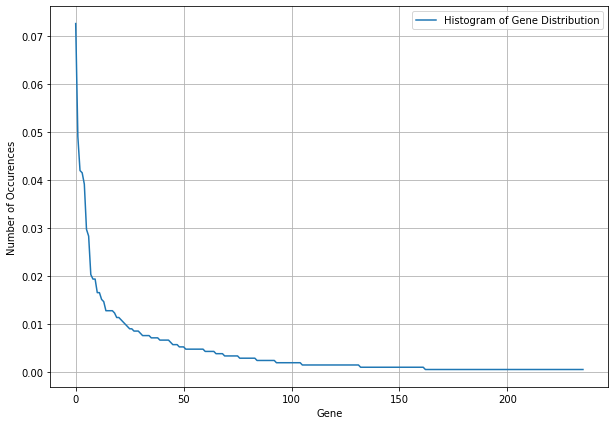

In [44]:
# distribution 
total_sum = sum(unique_genes.values)
dist = unique_genes.values / total_sum

plt.figure(figsize=(10, 7))
plt.plot(dist, label='Histogram of Gene Distribution')
plt.xlabel('Gene')
plt.ylabel('Number of Occurences')
plt.legend()
plt.grid()
plt.show();

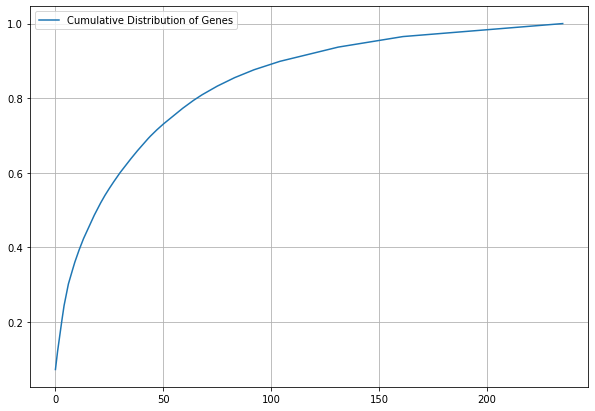

In [45]:
cum_sum = np.cumsum(dist)
plt.figure(figsize=(10, 7))
plt.plot(cum_sum, label='Cumulative Distribution of Genes')
plt.grid()
plt.legend()
plt.show()

***2. Featurization of Gene Feature***
- One-Hot Encoding
- Response Coding 

In [51]:
# Response Coding

alpha = 1
# gene feature in train data
train_gene_features_response_coding = np.array(get_feature(alpha, 'Gene', X_train))
# gene feature in validation data
val_gene_features_response_coding = np.array(get_feature(alpha, 'Gene', X_val))
# gene feature in test data
test_gene_features_response_coding = np.array(get_feature(alpha, 'Gene', X_test))

In [53]:
print(f"Shapes of the features after Response Codings:\n")
print(f"Train : {train_gene_features_response_coding.shape}")
print(f"Validation : {val_gene_features_response_coding.shape}")
print(f"Test : {test_gene_features_response_coding.shape}")

Shapes of the features after Response Codings:

Train : (2124, 9)
Validation : (532, 9)
Test : (665, 9)


In [56]:
# One-hot Encoding

gene_vectorizer = CountVectorizer()

# getting the features
train_gene_feature_onehot = gene_vectorizer.fit_transform(X_train['Gene'])
val_gene_feature_onehot = gene_vectorizer.transform(X_val['Gene'])
test_gene_feature_onehot = gene_vectorizer.transform(X_test['Gene'])

In [57]:
print(f"Shapes of the features after One-Hot Encoding: \n")
print(f"Train : {train_gene_feature_onehot.shape}")
print(f"Validation : {val_gene_feature_onehot.shape}")
print(f"Test : {test_gene_feature_onehot.shape}")

Shapes of the features after One-Hot Encoding: 

Train : (2124, 236)
Validation : (532, 236)
Test : (665, 236)


In [58]:
# getting the feature names
gene_labels = gene_vectorizer.get_feature_names()
gene_labels[:10]

['abl1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar', 'araf', 'arid1a']

***3. How Good is the Feature in Predicting Y?***
- we can use a machine learning model using just this feature to predict the Target Variable.
- we will be using a Logistic Regression Model using 'Gene' feature (one-hot encoded) or our case

In [61]:
# setting the hyperparameter for SGDClassifier 
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehot, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_gene_feature_onehot, y_train)
    
    preds = sig_clf.predict_proba(val_gene_feature_onehot)
    cv_log_error.append(log_loss(y_val, preds, labels=clf.classes_))
    
    print(f"For Aplha = {i} --> The Log Loss is = {log_loss(y_val, preds, labels=clf.classes_)}")

For Aplha = 1e-05 --> The Log Loss is = 1.1897974843066177
For Aplha = 0.0001 --> The Log Loss is = 1.1649615591529432
For Aplha = 0.001 --> The Log Loss is = 1.1993973311277482
For Aplha = 0.01 --> The Log Loss is = 1.3298530713185475
For Aplha = 0.1 --> The Log Loss is = 1.4398064840944016
For Aplha = 1 --> The Log Loss is = 1.473241819160498


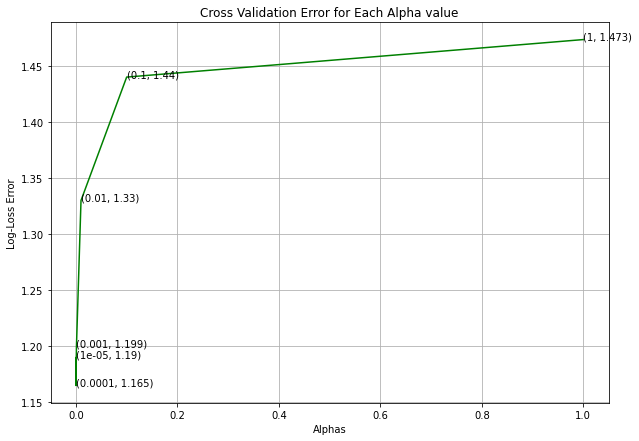

In [66]:
# plotting the results:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(alpha, cv_log_error, c='g')

for i, text in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(text, 3)), (alpha[i], cv_log_error[i]))
plt.grid()
plt.title('Cross Validation Error for Each Alpha value')
plt.xlabel('Alphas')
plt.ylabel('Log-Loss Error')
plt.show();

In [72]:
# finding the best alpha
best_alpha = alpha[np.argmin(cv_log_error)]
print(f"Value of best alpha = {best_alpha}")

Value of best alpha = 0.0001


In [74]:
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehot, y_train)

sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_gene_feature_onehot, y_train)

preds = sig_clf.predict_proba(train_gene_feature_onehot)
print(f'For Best Alpha value: {best_alpha}, The Train Log-loss is : {log_loss(y_train, preds, labels=clf.classes_)}')

preds = sig_clf.predict_proba(val_gene_feature_onehot)
print(f'For Best Alpha value: {best_alpha}, The Train Log-loss is : {log_loss(y_val, preds, labels=clf.classes_)}')

preds = sig_clf.predict_proba(test_gene_feature_onehot)
print(f'For Best Alpha value: {best_alpha}, The Train Log-loss is : {log_loss(y_test, preds, labels=clf.classes_)}')

For Best Alpha value: 0.0001, The Train Log-loss is : 0.982290879087094
For Best Alpha value: 0.0001, The Train Log-loss is : 1.1649615591529432
For Best Alpha value: 0.0001, The Train Log-loss is : 1.240228471543102


***4. Is 'Gene' feature stable accross Train, Test and Validation sets***

In [81]:
print(f"Total number of genes : {unique_genes.shape[0]}")

test_coverage = X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
val_coverage = X_val[X_val['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print(f"Coverage in the TEST data: {test_coverage} out of {X_test.shape[0]} ({test_coverage / X_test.shape[0]:.3%})")
print(f"Coverage in the VALIDATION data: {val_coverage} out of {X_val.shape[0]} ({val_coverage / X_val.shape[0]:.3%})")

Total number of genes : 236
Coverage in the TEST data: 642 out of 665 (96.541%)
Coverage in the VALIDATION data: 523 out of 532 (98.308%)


### (II) Univariate Analysis on 'VARIATION' Feature

***1. Number of Categories and Distribution***

In [14]:
unique_variations = X_train['Variation'].value_counts()
print(f"Number of unique Categories: {unique_variations.shape[0]}\n")
print(f"Top 10 Most occuring Features:")
print(unique_variations.head(10))

Number of unique Categories: 1923

Top 10 Most occuring Features:
Truncating_Mutations    66
Amplification           47
Deletion                42
Fusions                 23
Overexpression           4
T58I                     3
Q61L                     2
E17K                     2
S222D                    2
E542K                    2
Name: Variation, dtype: int64


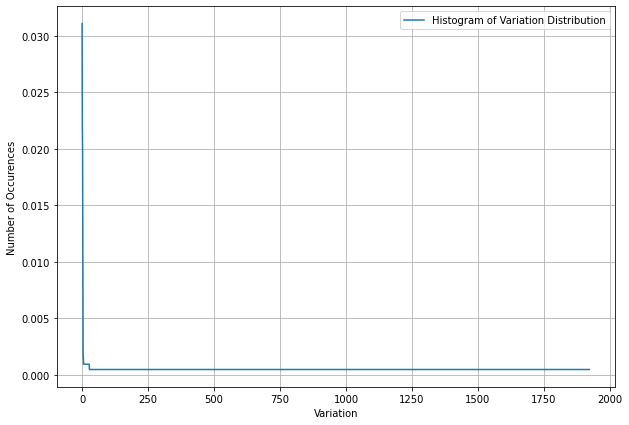

In [17]:
# distribution
total_sum = sum(unique_variations.values)
dist = unique_variations.values / total_sum

plt.figure(figsize=(10, 7))
plt.plot(dist, label='Histogram of Variation Distribution')
plt.xlabel('Variation')
plt.ylabel('Number of Occurences')
plt.legend()
plt.grid()
plt.show();

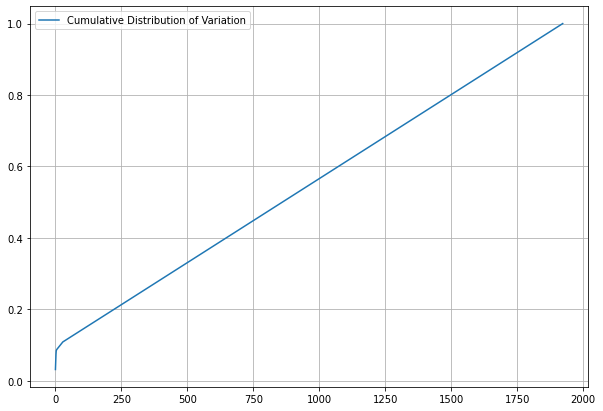

In [19]:
cum_sum = np.cumsum(dist)

plt.figure(figsize=(10, 7))
plt.plot(cum_sum, label='Cumulative Distribution of Variation')
plt.grid()
plt.legend()
plt.show();

***2. Featurization of Variation Feature***
- One-Hot Encoding
- Response Coding

In [20]:
# Response Coding 
alpha = 1

# variation feature in train data
train_variation_features_response_coding = np.array(get_feature(alpha, 'Variation', X_train))
# variation feature in validation data
val_variation_features_response_coding = np.array(get_feature(alpha, 'Variation', X_val))
# variation feature in test data
test_variation_features_response_coding = np.array(get_feature(alpha, 'Variation', X_test))

In [21]:
print(f"Shapes of the features after Response Codings:\n")
print(f"Train : {train_variation_features_response_coding.shape}")
print(f"Validation : {val_variation_features_response_coding.shape}")
print(f"Test : {test_variation_features_response_coding.shape}")

Shapes of the features after Response Codings:

Train : (2124, 9)
Validation : (532, 9)
Test : (665, 9)


In [22]:
# One-hot Encoding 
variation_vectorizer = CountVectorizer()

# getting the features
train_variation_features_onehot = variation_vectorizer.fit_transform(X_train['Variation'])
val_variation_features_onehot = variation_vectorizer.transform(X_val['Variation'])
test_variation_features_onehot = variation_vectorizer.transform(X_test['Variation'])

In [23]:
print(f"Shapes of the features after One-Hot Encoding: \n")
print(f"Train : {train_variation_features_onehot.shape}")
print(f"Validation : {val_variation_features_onehot.shape}")
print(f"Test : {test_variation_features_onehot.shape}")

Shapes of the features after One-Hot Encoding: 

Train : (2124, 1952)
Validation : (532, 1952)
Test : (665, 1952)


***3. How Good is the Feature in Predicting Y?***

- we can use a machine learning model using just this feature to predict the Target Variable.
- we will be using a Logistic Regression Model using 'Gene' feature (one-hot encoded) or our case

In [24]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_features_onehot, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_variation_features_onehot, y_train)
    preds = sig_clf.predict_proba(val_variation_features_onehot)
    
    cv_log_error.append(log_loss(y_val, preds, labels=clf.classes_))
    print(f"For Aplha = {i} --> The Log Loss is = {log_loss(y_val, preds, labels=clf.classes_)}")

For Aplha = 1e-05 --> The Log Loss is = 1.7064839179831701
For Aplha = 0.0001 --> The Log Loss is = 1.6997323424727562
For Aplha = 0.001 --> The Log Loss is = 1.7002157540400868
For Aplha = 0.01 --> The Log Loss is = 1.7044768447535121
For Aplha = 0.1 --> The Log Loss is = 1.7166940699499411
For Aplha = 1 --> The Log Loss is = 1.718464313019913


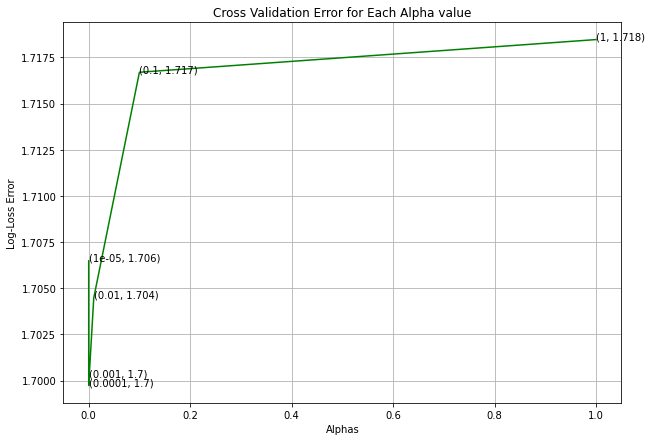

In [25]:
# plotting the results:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(alpha, cv_log_error, c='g')

for i, text in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(text, 3)), (alpha[i], cv_log_error[i]))
plt.grid()
plt.title('Cross Validation Error for Each Alpha value')
plt.xlabel('Alphas')
plt.ylabel('Log-Loss Error')
plt.show();

In [26]:
# finding the best alpha
best_alpha = alpha[np.argmin(cv_log_error)]
print(f"Value of best alpha = {best_alpha}")

Value of best alpha = 0.0001


In [29]:
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_features_onehot, y_train)

sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_variation_features_onehot, y_train)

preds = sig_clf.predict_proba(train_variation_features_onehot)
print(f'For Best Alpha value: {best_alpha}, The Train Log-loss is : {log_loss(y_train, preds, labels=clf.classes_)}')

preds = sig_clf.predict_proba(val_variation_features_onehot)
print(f'For Best Alpha value: {best_alpha}, The Train Log-loss is : {log_loss(y_val, preds, labels=clf.classes_)}')

preds = sig_clf.predict_proba(test_variation_features_onehot)
print(f'For Best Alpha value: {best_alpha}, The Train Log-loss is : {log_loss(y_test, preds, labels=clf.classes_)}')

For Best Alpha value: 0.0001, The Train Log-loss is : 0.6915188143664767
For Best Alpha value: 0.0001, The Train Log-loss is : 1.6997323424727562
For Best Alpha value: 0.0001, The Train Log-loss is : 1.7230993136874655


***4. Is 'Gene' feature stable accross Train, Test and Validation sets***

In [32]:
print(f"Total number of Variations: {unique_variations.shape[0]}")

test_coverage = X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
val_coverage = X_val[X_val['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

print(f"Coverage in the TEST data: {test_coverage} out of {X_test.shape[0]} ({test_coverage / X_test.shape[0]:.3%})")
print(f"Coverage in the VALIDATION data: {val_coverage} out of {X_val.shape[0]} ({val_coverage / X_val.shape[0]:.3%})")

Total number of Variations: 1923
Coverage in the TEST data: 67 out of 665 (10.075%)
Coverage in the VALIDATION data: 53 out of 532 (9.962%)


### (II) Univariate Analysis on 'TEXT' Feature

- *How many unique words are there in the `Text` feature.*
- *Word Frequencies distribution*
- *Featurization*
- *How useful is the feature*
- *Distribution across Train, Validation and Test sets*

In [21]:
# function to get the words
def extract_dictionary(df):
    dictionary = defaultdict(int)
    for index, row in df.iterrows():
        for word in row["TEXT"].split():
            dictionary[word] += 1;
    return dictionary    

In [22]:
dictionary = extract_dictionary(X_train)

In [36]:
# top 20 most occuring words in the vocabulary
sorted(dictionary, key=dictionary.get, reverse=True)[:20]

['mutations',
 '1',
 'cells',
 '2',
 '3',
 'cell',
 'mutation',
 'et',
 'al',
 '0',
 '5',
 'fig',
 'c',
 'cancer',
 'figure',
 'patients',
 '4',
 'protein',
 'expression',
 'activity']

In [37]:
# function to get response coding
def get_text_responsecoding(df):
    text_feature_responsecode = np.zeros((df.shape[0], 9))
    for i in range(0, 9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log((dict_list[i].get(word, 0) + 10) / (total_dict.get(word, 0) + 90))
            text_feature_responsecode[row_index][i] = math.exp(sum_prob / len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responsecode

In [38]:
# to store the dictionaries corresponding to each class, so in total 9
dict_list = []
for i in range(1, 10):
    cls_text = X_train[X_train['Class'] == i]
    dict_list.append(extract_dictionary(cls_text))

# to store the dictionary for all the words in the TEXT feature in X_train
total_dict = extract_dictionary(X_train)

***Featurization:***

In [40]:
# One-hot Encoding
text_vectorizer = CountVectorizer(min_df=3)

train_text_features_onehot = text_vectorizer.fit_transform(X_train['TEXT'])
valid_text_features_onehot = text_vectorizer.transform(X_val['TEXT'])
test_text_features_onehot = text_vectorizer.transform(X_test['TEXT'])

# normalizing the features:
train_text_features_onehot = normalize(train_text_features_onehot, axis=0)
valid_text_features_onehot = normalize(valid_text_features_onehot, axis=0)
test_text_features_onehot = normalize(test_text_features_onehot, axis=0)

In [42]:
print(f"Train: {train_text_features_onehot.shape}")
print(f"Validation: {valid_text_features_onehot.shape}")
print(f"Test: {test_text_features_onehot.shape}")

Train: (2124, 53295)
Validation: (532, 53295)
Test: (665, 53295)


In [44]:
# Response Coding 
train_text_responsecoding = get_text_responsecoding(X_train)
valid_text_responsecoding = get_text_responsecoding(X_val)
test_text_responsecoding = get_text_responsecoding(X_test)

# convert each row values such that they sum to 1  (normalizing)
train_text_responsecoding = (train_text_responsecoding.T / train_text_responsecoding.sum(axis=1)).T
valid_text_responsecoding = (valid_text_responsecoding.T / valid_text_responsecoding.sum(axis=1)).T
test_text_responsecoding = (test_text_responsecoding.T / test_text_responsecoding.sum(axis=1)).T

In [49]:
print(f"Train: {train_text_responsecoding.shape}")
print(f"Validation: {valid_text_responsecoding.shape}")
print(f"Test: {test_text_responsecoding.shape}")

Train: (2124, 9)
Validation: (532, 9)
Test: (665, 9)


***How good is the Feature for prediction***

In [52]:
# alpha hyperparameter
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, loss='log', penalty='l2', random_state=42)
    clf.fit(train_text_features_onehot, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_text_features_onehot, y_train)
    preds = sig_clf.predict_proba(valid_text_features_onehot)
    
    cv_log_error.append(log_loss(y_val, preds, labels=clf.classes_))
    print(f"For Aplha = {i} --> The Log Loss is = {log_loss(y_val, preds, labels=clf.classes_)}")

For Aplha = 1e-05 --> The Log Loss is = 1.2914640556143469
For Aplha = 0.0001 --> The Log Loss is = 1.162501578206787
For Aplha = 0.001 --> The Log Loss is = 1.1526935974107262
For Aplha = 0.01 --> The Log Loss is = 1.2158661038549101
For Aplha = 0.1 --> The Log Loss is = 1.4386728816178431
For Aplha = 1 --> The Log Loss is = 1.636537127705796


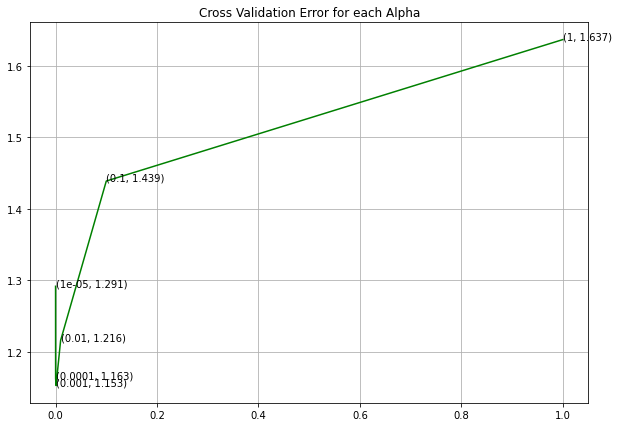

In [53]:
# plotting the results
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(alpha, cv_log_error, c='g')
for i, text in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(text, 3)), (alpha[i], cv_log_error[i]))
    
plt.grid()
plt.title('Cross Validation Error for each Alpha')
plt.show();

In [55]:
# best alpha
best_alpha = alpha[np.argmin(cv_log_error)]
best_alpha

0.001

In [56]:
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_text_features_onehot, y_train)

sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_text_features_onehot, y_train)

preds = sig_clf.predict_proba(train_text_features_onehot)
print(f"Best Alpha = {best_alpha}, Log Loss Train = {log_loss(y_train, preds, labels=clf.classes_)}")
preds = sig_clf.predict_proba(valid_text_features_onehot)
print(f"Best Alpha = {best_alpha}, Log Loss for Validation = {log_loss(y_val, preds, labels=clf.classes_)}")
preds = sig_clf.predict_proba(test_text_features_onehot)
print(f"Best Alpha = {best_alpha}, Log Loss for Test = {log_loss(y_test, preds, labels=clf.classes_)}")

Best Alpha = 0.001, Log Loss Train = 0.639412810414066
Best Alpha = 0.001, Log Loss for Validation = 1.1526935974107262
Best Alpha = 0.001, Log Loss for Test = 1.3122220272900456
